In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
actions = [
    'ONE',
    'TWO',
    'THREE',
    'FOUR',
    'FIVE',
    'ZERO'
]

data = np.concatenate([
    np.load('dataset/seq_ONE_1662628138.npy'),
    np.load('dataset/seq_TWO_1662628138.npy'),
    np.load('dataset/seq_THREE_1662628138.npy'),
    np.load('dataset/seq_FOUR_1662628138.npy'),
    np.load('dataset/seq_FIVE_1662628138.npy'),
    np.load('dataset/seq_ZERO_1662628138.npy')
], axis=0)

data.shape

(2677, 5, 100)

In [5]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2677, 5, 99)
(2677,)


In [6]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2677, 6)

In [7]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2409, 5, 99) (2409, 6)
(268, 5, 99) (268, 6)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 44,262
Trainable params: 44,262
Non-trainable params: 0
_________________________________________________________________


2022-09-08 18:14:57.797780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
64/76 [========================>.....] - ETA: 0s - loss: 2.6140 - acc: 0.7334
Epoch 1: val_acc improved from -inf to 0.93284, saving model to models/model.h5
76/76 [==============================] - 2s 7ms/step - loss: 2.2680 - acc: 0.7609 - val_loss: 0.2721 - val_acc: 0.9328 - lr: 0.0010
Epoch 2/200
76/76 [==============================] - ETA: 0s - loss: 0.1494 - acc: 0.9556
Epoch 2: val_acc improved from 0.93284 to 0.95149, saving model to models/model.h5
76/76 [==============================] - 0s 3ms/step - loss: 0.1494 - acc: 0.9556 - val_loss: 0.1642 - val_acc: 0.9515 - lr: 0.0010
Epoch 3/200
73/76 [===========================>..] - ETA: 0s - loss: 0.0615 - acc: 0.9807
Epoch 3: val_acc improved from 0.95149 to 0.96269, saving model to models/model.h5
76/76 [==============================] - 0s 4ms/step - loss: 0.0606 - acc: 0.9809 - val_loss: 0.1125 - val_acc: 0.9627 - lr: 0.0010
Epoch 4/200
75/76 [============================>.] - ETA: 0s - loss: 0.0368 - acc: 0.988

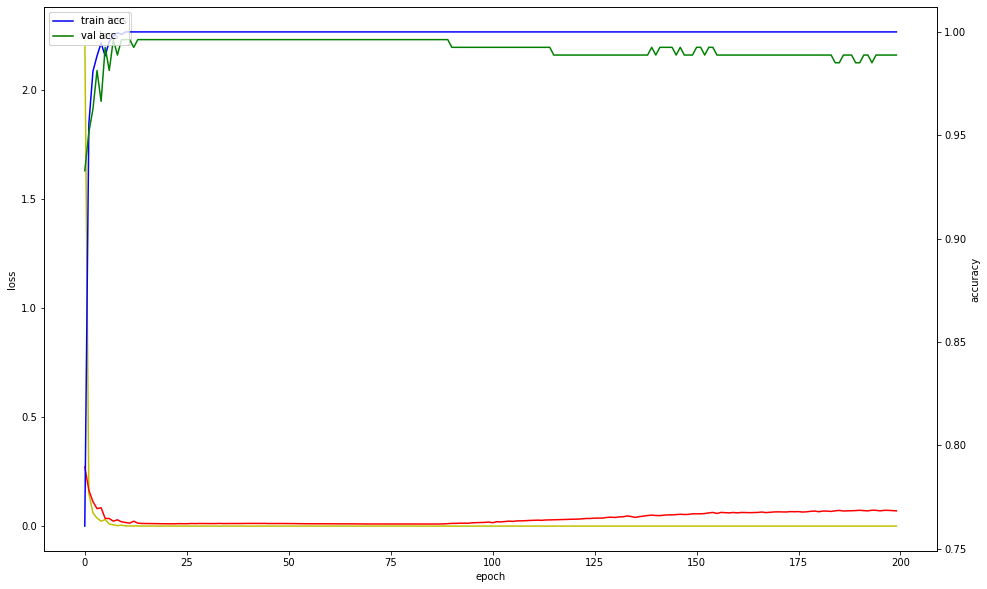

In [10]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [11]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

9/9 [==============================] - 0s 1ms/step


array([[[220,   0],
        [  1,  47]],

       [[223,   0],
        [  0,  45]],

       [[218,   0],
        [  0,  50]],

       [[227,   0],
        [  0,  41]],

       [[226,   0],
        [  0,  42]],

       [[225,   1],
        [  0,  42]]])